## Test different modeling approaches

In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Sklearn imports - all in one place to avoid scattered imports
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Gradient Boosting imports
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✅ LightGBM available")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not available. Install with: pip install lightgbm")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\n🔬 Box Office Prediction: Experimental Modeling Approaches")
print("=" * 60)
print("📊 All libraries imported and ready for experimentation")
print("🎯 Goal: Test different modeling approaches for 2026 predictions")
print(f"💡 Available models: Ridge, Decision Tree, Random Forest{', XGBoost' if XGBOOST_AVAILABLE else ''}{', LightGBM' if LIGHTGBM_AVAILABLE else ''}")

✅ XGBoost available
✅ LightGBM available

🔬 Box Office Prediction: Experimental Modeling Approaches
📊 All libraries imported and ready for experimentation
🎯 Goal: Test different modeling approaches for 2026 predictions
💡 Available models: Ridge, Decision Tree, Random Forest, XGBoost, LightGBM


In [2]:
# Load the processed dataset
df = pd.read_csv('../data/dataset_domestic_processed.csv')

print(f"Dataset loaded: {df.shape[0]} movies, {df.shape[1]} features")
print(f"Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}")
print(f"Average revenue: ${df['revenue_domestic'].mean():,.0f}")

# Display basic info
print(f"\nRevenue distribution by year:")
yearly_stats = df.groupby('release_year')['revenue_domestic'].agg(['count', 'mean', 'median', 'max']).round(0)
print(yearly_stats)

Dataset loaded: 890 movies, 94 features
Date range: 2015-2025
Revenue range: $521,202 - $936,662,225
Average revenue: $95,506,997

Revenue distribution by year:
              count         mean      median          max
release_year                                             
2015            107   97742561.0  56451232.0  936662225.0
2016            102   99563413.0  62495504.0  533539991.0
2017             93  108981255.0  58060186.0  620181382.0
2018            102  102620565.0  54794738.0  700426566.0
2019            111   98730850.0  45896028.0  858373000.0
2020             30   38470323.0  16381926.0  206305244.0
2021             68   65699426.0  39328846.0  814866759.0
2022             70  102583466.0  55917737.0  718732821.0
2023             78   95564793.0  62749098.0  636238421.0
2024             73  103337791.0  42777281.0  652980194.0
2025             56   89739293.0  43264974.0  423949195.0


In [3]:
df

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,release_year,genres,title_normalized,domestic_revenue,rank,distributor,revenue_domestic,revenue,is_disney,is_warner_bros,is_universal,is_sony,is_paramount,is_fox,is_mgm,is_lionsgate,is_major_studio,genre_names,genre_drama,genre_comedy,genre_thriller,genre_action,genre_adventure,genre_horror,genre_science_fiction,genre_family,genre_crime,genre_fantasy,genre_romance,genre_mystery,genre_history,genre_animation,genre_music,genre_war,genre_western,is_action_adventure,is_action_sci_fi,is_comedy_romance,is_family_animation,primary_genre,genre_count,release_month,release_month_name,release_season,is_summer_blockbuster,is_holiday_release,is_oscar_season,is_holiday_proximity,nearest_holiday,days_to_holiday,is_christmas_proximity,is_thanksgiving_proximity,is_independence_day_proximity,is_memorial_labor_day_proximity,has_nearby_major_release,nearby_major_releases_count,nearby_major_releases_max_revenue,days_to_nearest_major_release,competition_intensity,has_blockbuster_competition,has_immediate_competition,is_sequel_title,is_marvel,is_dc,is_star_wars,is_fast_furious,is_harry_potter,is_franchise_sequel,is_sequel,is_live_action_remake,is_adaptation,is_superhero,has_remake_indicator,is_remake_adaptation,is_ip_movie,years_since_baseline,is_pre_streaming_era,is_streaming_transition,is_pandemic_year,is_post_pandemic_era
0,False,/aan0KdhVgJfAwUJ3n2HDFOWcxZ2.jpg,[35],252838,en,The Wedding Ringer,Doug Harris is a loveable but socially awkward...,3.1703,/ciR2suRkfJen9lQvfz22lgCj7g7.jpg,2015-01-16,The Wedding Ringer,False,6.460,1625,2015,[35],The Wedding Ringer,64460211.0,1449.0,Screen Gems,64460211.0,64460211.0,0,0,0,1,0,0,0,0,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,1,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,1.0,0,0,0,0,0,0,0,NaN,Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,False,/1u7TuvR5mSUz2xRQhz01i75IwdT.jpg,"[80, 53, 28]",201088,en,Blackhat,"Nicholas Hathaway, a furloughed convict, and h...",9.5554,/7zu6HPnKPjNA7NuR4DGRdaH0PdX.jpg,2015-01-16,Blackhat,False,5.512,2095,2015,"[80, 53, 28]",Blackhat,8005980.0,5583.0,Universal Pictures,8005980.0,8005980.0,0,0,1,0,0,0,0,0,1,"Crime,Thriller,Action",0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Crime,3,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,1.0,0,0,0,0,1,1,64460211,0.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,False,/aUbyQhWcPS7S0Su2d9Tgk3NxdPk.jpg,"[10402, 16, 10751, 14]",302429,en,Strange Magic,A love potion works its devious charms on fair...,4.4907,/vjCdrK8gGRFnyuZb1j9BzgN2RaY.jpg,2015-01-23,Strange Magic,False,7.200,526,2015,"[10402, 16, 10751, 14]",Strange Magic,12429583.0,4831.0,Walt Disney Studios Motion Pictures,12429583.0,12429583.0,1,0,0,0,0,0,0,0,1,"Music,Animation,Family,Fantasy",0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,Music,4,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,False,/6Sg4UUs0OksCbR0TZxUtQWPOMDV.jpg,"[35, 12]",210860,en,Mortdecai,"An art dealer, Charles Mortdecai, searches for...",4.1565,/zIRDhdAuMevOuY2vs3s1HNcqDq7.jpg,2015-01-23,Mortdecai,False,5.500,2688,2015,"[35, 12]",Mortdecai,7696134.0,5640.0,Lionsgate,7696134.0,7696134.0,0,0,0,0,0,0,0,1,1,"Comedy,Adventure",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy,2,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Medium,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,/96iXwJibeNW9RGEa58zYa0SQV6m.jpg,[53],241251,en,The Boy Next Door,A recently cheated on married woman falls for ...,3.5103,/gicmSeLG6Uh7BF1r1mxZHUQ8r26.jpg,2015-01-23,The Boy Next Door,False,4.900,2067,2015,[53],The Boy Next Door,35423380.0,2624.0,Universal Pictures,35423380.0,35423380.0,0,0,1,0,0,0,0,0,1,Thriller,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Thriller,1,1,January,Winter,0,0,0,1,Martin Luther King Jr. Day,8.0,0,0,0,0,1,2,162994032,7.0,Me

### Define Features to Use

In [4]:
# Define feature columns (exclude metadata and target) + Add alternative time features
exclude_cols = [
    # Metadata columns
    'adult', 'backdrop_path', 'genre_ids', 'id', 'original_language', 'original_title', 
    'overview', 'poster_path', 'release_date', 'title', 'video', 'genres', 
    'title_normalized', 'rank', 'distributor', 'genre_names', 'release_month_name',
    'nearest_holiday', 'nearby_major_releases_max_revenue', 'days_to_nearest_major_release',
    
    # Target variables
    'domestic_revenue', 'revenue_domestic', 'revenue',
    
    # String/categorical columns that need special handling
    'primary_genre', 'release_season', 'competition_intensity',
    
    # TMDb post-release features (potential data leakage)
    'popularity', 'vote_average', 'vote_count',
    
    # REMOVED: release_year (replaced with alternative time features)
    'release_year'
]

# Get all columns first
all_cols = df.columns.tolist()

# Get potential feature columns
potential_features = [col for col in all_cols if col not in exclude_cols]

# Only keep numeric columns for baseline models
numeric_features = []
for col in potential_features:
    if df[col].dtype in ['int64', 'float64', 'bool', 'int32', 'float32']:
        numeric_features.append(col)
    elif df[col].dtype == 'object':
        # Check if it's binary string (like 'True'/'False' or '0'/'1')
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) <= 2:
            print(f"Including binary-like string column: {col} (values: {unique_vals})")
            numeric_features.append(col)
        else:
            print(f"Excluding string column: {col} (values: {unique_vals[:5]}...)")

feature_cols = numeric_features

# Remove is_major_studio from features (since all are now major studios)
feature_cols_focused = [col for col in feature_cols if col != 'is_major_studio']

# Update dataframe and feature columns
feature_cols = feature_cols_focused

# Target variable
target = 'revenue_domestic'

print(f"\nTarget variable: {target}")
print(f"Missing values in target: {df[target].isnull().sum()}")

# Check for missing values in features
missing_features = df[feature_cols].isnull().sum()
features_with_missing = missing_features[missing_features > 0]
if len(features_with_missing) > 0:
    print(f"Features with missing values:")
    print(features_with_missing)
else:
    print(f"No missing values in features ✅")


Target variable: revenue_domestic
Missing values in target: 0
Features with missing values:
days_to_holiday    441
dtype: int64


## 🔵 Approach 1: Ridge Regression (Linear Models)

**Why Ridge Regression?**
- Strong baseline for box office prediction
- Handles multicollinearity well (important with 63 features)
- Interpretable coefficients show feature importance
- Regularization prevents overfitting

**Experimental Design:**
- Test 3 pandemic handling strategies: All Years, No Pandemic, Weighted (30%)
- Hyperparameter tuning with Grid Search
- Compare strategies on 2024 validation data

**Expected Outcome**: Find best Ridge configuration and pandemic strategy for final comparison.

### Multiple Training Strategies

In [5]:
# Create multiple training strategies
print("🔄 Creating Training Strategies")
print("=" * 70)

# Strategy 1: Include all years (2015-2023) - All eras included
train_data_all = df[df['release_year'].between(2015, 2023)].copy()

# Strategy 2: Exclude pandemic year (2015-2019, 2021-2023) - Using era features to handle this
train_data_no_pandemic = df[df['is_pandemic_year'] == 0].copy()  # Exclude pandemic era
train_data_no_pandemic = train_data_no_pandemic[train_data_no_pandemic['release_year'] <= 2023]

# Strategy 3: Weight pandemic year less (keep but reduce influence) - Weight based on era
train_data_weighted = df[df['release_year'].between(2015, 2023)].copy()
# Create sample weights - reduce weight for pandemic era
sample_weights = np.ones(len(train_data_weighted))
pandemic_mask = train_data_weighted['is_pandemic_year'] == 1  # Using era feature
sample_weights[pandemic_mask] = 0.3  # Give 30% weight to pandemic year

print(f"Strategy 1 (All eras):         {len(train_data_all)} movies")
print(f"Strategy 2 (No pandemic era):  {len(train_data_no_pandemic)} movies (excludes pandemic era)")
print(f"Strategy 3 (Weighted):         {len(train_data_weighted)} movies (pandemic era weighted at 30%)")

# Validation data remains the same for all strategies
val_data = df[df['release_year'] == 2024].copy()
test_data = df[df['release_year'] == 2025].copy()

print(f"\nValidation (2024): {len(val_data)} movies")
print(f"Test (2025):       {len(test_data)} movies")

# Show era distributions in datasets
print(f"\n🎭 Era distributions in training strategies:")
for strategy_name, data in [("All eras", train_data_all), ("No pandemic", train_data_no_pandemic), ("Weighted", train_data_weighted)]:
    print(f"\n{strategy_name}:")
    print(f"  Pre-streaming: {data['is_pre_streaming_era'].sum()}")
    print(f"  Transition: {data['is_streaming_transition'].sum()}")
    print(f"  Pandemic: {data['is_pandemic_year'].sum()}")
    print(f"  Post-pandemic: {data['is_post_pandemic_era'].sum()}")

def train_strategy_models(train_data, strategy_name, sample_weights=None):
    """Train models"""
    print(f"\n🤖 Training models - {strategy_name}")
    
    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)
    
    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)
    
    # Train Ridge with this strategy
    ridge_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('ridge', Ridge())
    ])
    
    ridge_params = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
    
    ridge_grid = GridSearchCV(
        ridge_pipeline, ridge_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # Fit with sample weights if provided
    if sample_weights is not None:
        # Note: GridSearchCV doesn't directly support sample weights
        # We'll use the best alpha from unweighted search, then refit with weights
        ridge_grid.fit(X_train_strat, y_train_strat_log)
        best_alpha = ridge_grid.best_params_['ridge__alpha']
        
        # Refit with weights
        ridge_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        ridge_weighted.fit(X_train_strat, y_train_strat_log, ridge__sample_weight=sample_weights)
        ridge_best = ridge_weighted
    else:
        ridge_grid.fit(X_train_strat, y_train_strat_log)
        ridge_best = ridge_grid.best_estimator_
    
    # Evaluate
    results = evaluate_model(ridge_best, X_val, y_val_log, y_val, f"Ridge - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = ridge_best
    
    return results

print("✅ Strategy framework ready")

🔄 Creating Training Strategies
Strategy 1 (All eras):         761 movies
Strategy 2 (No pandemic era):  731 movies (excludes pandemic era)
Strategy 3 (Weighted):         761 movies (pandemic era weighted at 30%)

Validation (2024): 73 movies
Test (2025):       56 movies

🎭 Era distributions in training strategies:

All eras:
  Pre-streaming: 404
  Transition: 179
  Pandemic: 30
  Post-pandemic: 148

No pandemic:
  Pre-streaming: 404
  Transition: 179
  Pandemic: 0
  Post-pandemic: 148

Weighted:
  Pre-streaming: 404
  Transition: 179
  Pandemic: 30
  Post-pandemic: 148
✅ Strategy framework ready


In [6]:
# Import additional required libraries
from sklearn.impute import SimpleImputer

# Model evaluation function
def evaluate_model(model, X_val, y_val_log, y_val_actual, model_name):
    """Evaluate model performance on validation set"""
    # Predict in log space
    y_pred_log = model.predict(X_val)
    
    # Transform back to original scale
    y_pred = np.expm1(y_pred_log)
    
    # Calculate metrics in original scale (dollars)
    mse = mean_squared_error(y_val_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_actual, y_pred)
    r2 = r2_score(y_val_actual, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_val_actual - y_pred) / y_val_actual)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE:  ${mae:,.0f}")
    print(f"  MAPE: {mape:.1f}%")
    print(f"  R²:   {r2:.3f}")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'predictions': y_pred
    }

# Function to get top 10 predictions for any year
def get_top10_predictions(model, data, year, feature_cols, target_col='revenue_domestic'):
    """
    Get top 10 box office predictions for a given year
    """
    year_data = data[data['release_year'] == year].copy()
    
    if len(year_data) == 0:
        print(f"No data found for year {year}")
        return None
    
    # Get features and make predictions
    X_year = year_data[feature_cols]
    y_pred_log = model.predict(X_year)
    y_pred = np.expm1(y_pred_log)
    
    # Add predictions to dataframe
    year_data = year_data.copy()
    year_data['predicted_revenue'] = y_pred
    
    # Get actual revenue if available
    if target_col in year_data.columns:
        year_data['actual_revenue'] = year_data[target_col]
        year_data['prediction_error'] = year_data['actual_revenue'] - year_data['predicted_revenue']
        year_data['prediction_error_pct'] = (year_data['prediction_error'] / year_data['actual_revenue']) * 100
    
    # Sort by predicted revenue (descending) and get top 10
    top10 = year_data.nlargest(10, 'predicted_revenue')
    
    # Select relevant columns for display
    display_cols = ['title', 'predicted_revenue']
    if target_col in year_data.columns:
        display_cols.extend(['actual_revenue', 'prediction_error', 'prediction_error_pct'])
    
    # Add key feature flags for context
    feature_flags = ['is_marvel', 'is_dc', 'is_star_wars', 'is_superhero', 'is_sequel', 
                    'is_live_action_remake', 'is_major_studio', 'is_disney']
    available_flags = [col for col in feature_flags if col in year_data.columns]
    display_cols.extend(available_flags)
    
    return top10[display_cols].reset_index(drop=True)

print("✅ Evaluation and prediction functions ready")

✅ Evaluation and prediction functions ready


In [7]:
print("""📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).""")

# Train models with all three strategies using alternative time features
strategy_results = []

# Strategy 1: All eras including pandemic
results_all = train_strategy_models(train_data_all, "All Eras (2015-2023)")
strategy_results.append(results_all)

# Strategy 2: Exclude pandemic era
results_no_pandemic = train_strategy_models(train_data_no_pandemic, "No Pandemic Era")
strategy_results.append(results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
results_weighted = train_strategy_models(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
strategy_results.append(results_weighted)

📊 Metrics Recap. 
- RMSE (Root Mean Squared Error): Average size of errors, penalizing large errors more heavily.  
- MAE (Mean Absolute Error): Average size of errors in plain dollar terms.  
- MAPE (Mean Absolute Percentage Error): Average percentage error. Over 100% means predictions are, on average, larger than the true values. 
- R² (Coefficient of Determination): Measures how much variance is explained by the model (0 = no explanatory power, 1 = perfect prediction).

🤖 Training models - All Eras (2015-2023)

Ridge - All Eras (2015-2023) Performance:
  RMSE: $127,723,346
  MAE:  $69,139,739
  MAPE: 132.6%
  R²:   0.154

🤖 Training models - No Pandemic Era

Ridge - No Pandemic Era Performance:
  RMSE: $126,935,522
  MAE:  $68,583,722
  MAPE: 137.3%
  R²:   0.164

🤖 Training models - Weighted (30% pandemic era)

Ridge - Weighted (30% pandemic era) Performance:
  RMSE: $127,279,346
  MAE:  $68,827,219
  MAPE: 135.4%
  R²:   0.160



📊 Strategy Comparison Results
                   Strategy         RMSE         MAE   MAPE    R²
       All Eras (2015-2023) $127,723,346 $69,139,739 132.6% 0.154
            No Pandemic Era $126,935,522 $68,583,722 137.3% 0.164
Weighted (30% pandemic era) $127,279,346 $68,827,219 135.4% 0.160

🏆 Best Strategy: No Pandemic Era
   Validation RMSE: $126,935,522
   This will be used for 2026 predictions


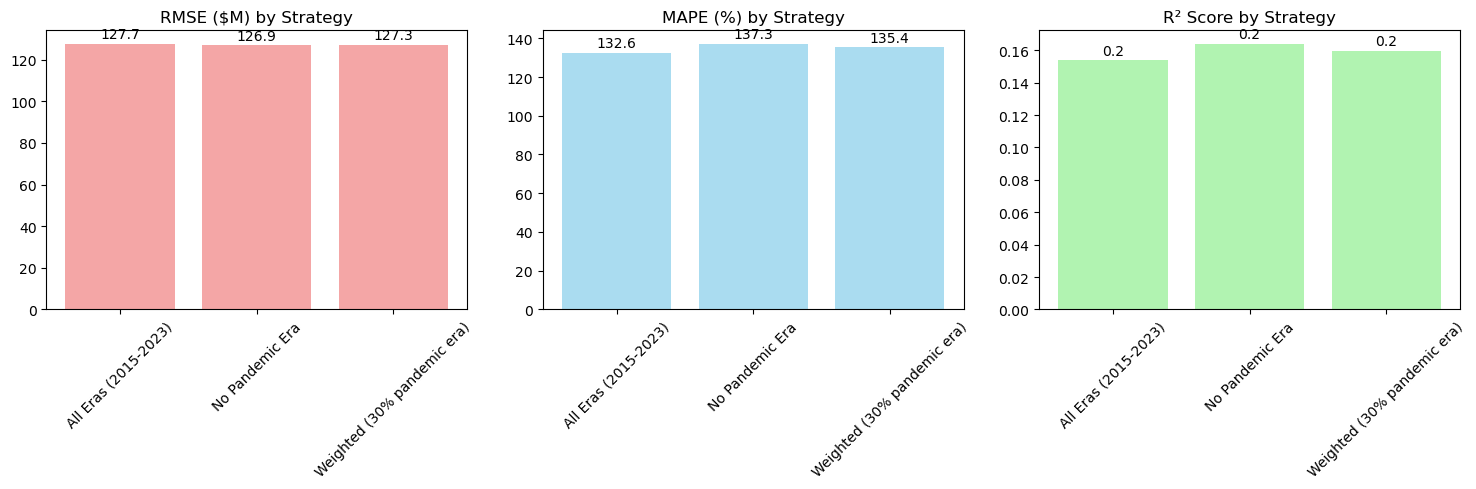

✅ Pandemic-aware model selection complete


In [8]:
# Compare strategies
print("\n📊 Strategy Comparison Results")
print("=" * 70)

strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in strategy_results
])

print(strategy_comparison.to_string(index=False))

# Find best strategy
best_strategy_idx = min(range(len(strategy_results)), key=lambda i: strategy_results[i]['rmse'])
best_strategy = strategy_results[best_strategy_idx]

print(f"\n🏆 Best Strategy: {best_strategy['strategy']}")
print(f"   Validation RMSE: ${best_strategy['rmse']:,.0f}")
print(f"   This will be used for 2026 predictions")

# Store best model
best_model_pandemic_aware = best_strategy['model_object']

# Visualize strategy comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['rmse', 'mape', 'r2']
metric_names = ['RMSE ($M)', 'MAPE (%)', 'R² Score']
colors = ['lightcoral', 'skyblue', 'lightgreen']

for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
    values = [r[metric] for r in strategy_results]
    strategies = [r['strategy'] for r in strategy_results]
    
    if metric == 'rmse':
        values = [v/1e6 for v in values]  # Convert to millions for readability
    
    bars = axes[i].bar(strategies, values, color=color, alpha=0.7)
    axes[i].set_title(f'{name} by Strategy')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("✅ Pandemic-aware model selection complete")

## 🌳 Approach 2: Decision Trees (Non-Linear Models)

**Why Decision Trees?**
- Captures non-linear relationships and feature interactions
- Naturally handles mixed data types and feature importance
- No assumption about data distribution
- Interpretable decision rules

**Experimental Design:**
- Same 3 pandemic strategies as Ridge (All Years, No Pandemic, Weighted)
- Hyperparameter tuning: max_depth, min_samples_split, min_samples_leaf, max_features
- Feature importance analysis to understand key predictors
- Compare against Ridge baseline

**Expected Outcome**: Test whether non-linear modeling improves over Ridge regression.

In [9]:
# Import Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

print("🌳 Setting up Decision Tree Regression Models")

def train_decision_tree_strategies(train_data, strategy_name, sample_weights=None):
    """Train Decision Tree models with a specific strategy"""
    print(f"\n🌳 Training Decision Tree - {strategy_name}")
    
    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)
    
    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)
    
    # Decision Tree pipeline (no scaling needed for trees)
    dt_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('dt', DecisionTreeRegressor(random_state=42))
    ])
    
    # Hyperparameter grid for Decision Tree
    dt_params = {
        'dt__max_depth': [5, 6, 7, 8, 9, 10],
        'dt__min_samples_split': [10, 20, 50],
        'dt__min_samples_leaf': [5, 10, 15],
        'dt__max_features': ['sqrt', 'log2', None]
    }
    
    dt_grid = GridSearchCV(
        dt_pipeline, dt_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights for Decision Trees
        # We'll use best params from unweighted search, then refit with weights
        dt_grid.fit(X_train_strat, y_train_strat_log)
        best_params = dt_grid.best_params_
        
        # Refit with weights
        dt_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('dt', DecisionTreeRegressor(
                max_depth=best_params['dt__max_depth'],
                min_samples_split=best_params['dt__min_samples_split'],
                min_samples_leaf=best_params['dt__min_samples_leaf'],
                max_features=best_params['dt__max_features'],
                random_state=42
            ))
        ])
        dt_weighted.fit(X_train_strat, y_train_strat_log, dt__sample_weight=sample_weights)
        dt_best = dt_weighted
        print(f"  Best params: {best_params}")
    else:
        dt_grid.fit(X_train_strat, y_train_strat_log)
        dt_best = dt_grid.best_estimator_
        print(f"  Best params: {dt_grid.best_params_}")
    
    # Evaluate
    results = evaluate_model(dt_best, X_val, y_val_log, y_val, f"Decision Tree - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = dt_best
    results['model_type'] = 'Decision Tree'
    
    return results

print("✅ Decision Tree framework ready")

🌳 Setting up Decision Tree Regression Models
✅ Decision Tree framework ready


In [10]:
# Train Decision Tree models with all three strategies
dt_strategy_results = []

# Strategy 1: All eras including pandemic
dt_results_all = train_decision_tree_strategies(train_data_all, "All Eras (2015-2023)")
dt_strategy_results.append(dt_results_all)

# Strategy 2: Exclude pandemic era
dt_results_no_pandemic = train_decision_tree_strategies(train_data_no_pandemic, "No Pandemic Era")
dt_strategy_results.append(dt_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
dt_results_weighted = train_decision_tree_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
dt_strategy_results.append(dt_results_weighted)


🌳 Training Decision Tree - All Eras (2015-2023)
  Best params: {'dt__max_depth': 6, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 10}

Decision Tree - All Eras (2015-2023) Performance:
  RMSE: $125,449,024
  MAE:  $72,557,290
  MAPE: 156.6%
  R²:   0.184

🌳 Training Decision Tree - No Pandemic Era
  Best params: {'dt__max_depth': 6, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 20}

Decision Tree - No Pandemic Era Performance:
  RMSE: $129,631,390
  MAE:  $73,498,285
  MAPE: 128.5%
  R²:   0.128

🌳 Training Decision Tree - Weighted (30% pandemic era)
  Best params: {'dt__max_depth': 6, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 10}

Decision Tree - Weighted (30% pandemic era) Performance:
  RMSE: $119,866,144
  MAE:  $69,767,074
  MAPE: 163.5%
  R²:   0.255


In [11]:
# Compare Decision Tree strategies
print("\n📊 Decision Tree Strategy Comparison")
print("=" * 70)

dt_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in dt_strategy_results
])

print(dt_strategy_comparison.to_string(index=False))

# Find best Decision Tree strategy
best_dt_strategy_idx = min(range(len(dt_strategy_results)), key=lambda i: dt_strategy_results[i]['rmse'])
best_dt_strategy = dt_strategy_results[best_dt_strategy_idx]

print(f"\n🏆 Best Decision Tree Strategy: {best_dt_strategy['strategy']}")
print(f"   Validation RMSE: ${best_dt_strategy['rmse']:,.0f}")

# Store best Decision Tree model
best_dt_model = best_dt_strategy['model_object']


📊 Decision Tree Strategy Comparison
                   Strategy         RMSE         MAE   MAPE    R²
       All Eras (2015-2023) $125,449,024 $72,557,290 156.6% 0.184
            No Pandemic Era $129,631,390 $73,498,285 128.5% 0.128
Weighted (30% pandemic era) $119,866,144 $69,767,074 163.5% 0.255

🏆 Best Decision Tree Strategy: Weighted (30% pandemic era)
   Validation RMSE: $119,866,144



🔍 Feature Importance Analysis
Top 15 Most Important Features:
             feature  importance
        is_superhero    0.293465
         is_ip_movie    0.177974
     is_sequel_title    0.162268
        is_lionsgate    0.135178
           is_disney    0.061367
             is_sony    0.038487
     genre_adventure    0.034380
       release_month    0.028220
     days_to_holiday    0.015784
years_since_baseline    0.012176
 is_action_adventure    0.011712
  is_holiday_release    0.011259
      genre_thriller    0.005428
           is_marvel    0.004802
is_holiday_proximity    0.002951


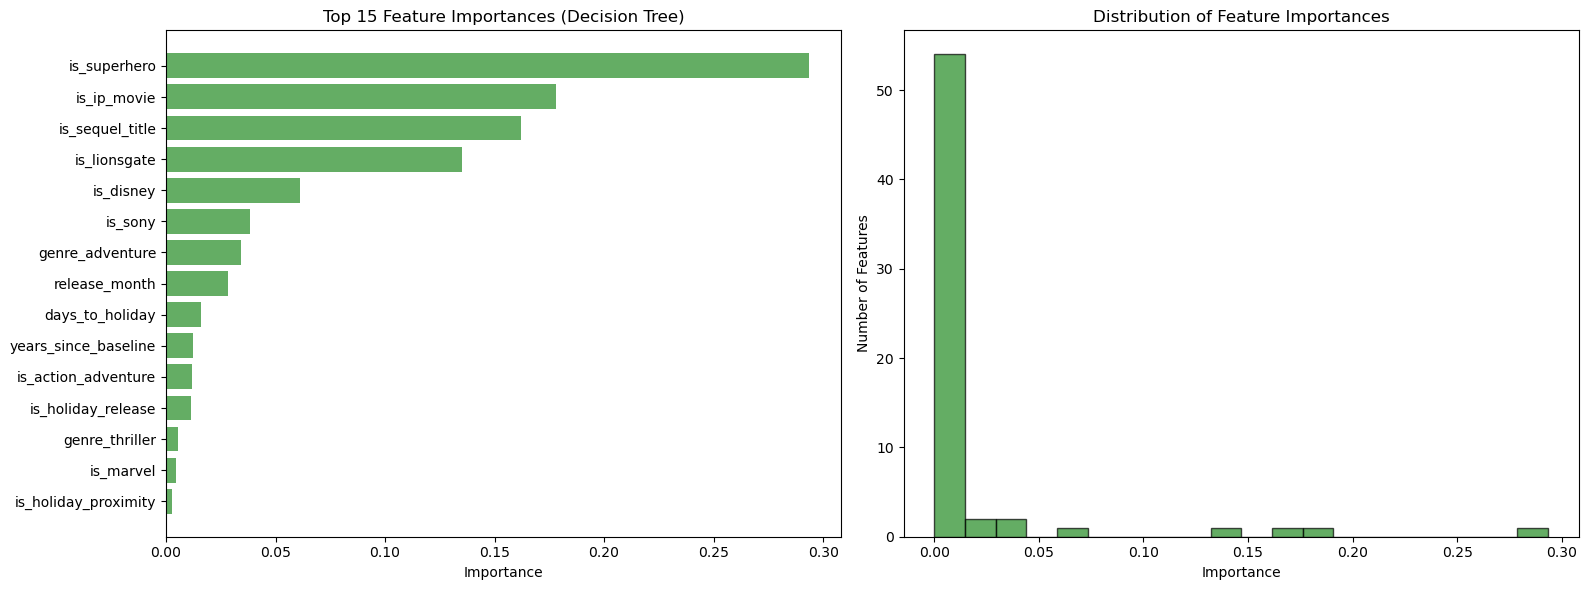


📈 Feature Analysis Summary:
   Total features: 63
   Features with importance > 0.01: 12
   Top 5 features account for: 83.0% of total importance


In [12]:
# Feature Importance Analysis (unique to Decision Trees)
print("\n🔍 Feature Importance Analysis")
print("=" * 50)

# Get feature importances from best Decision Tree model
dt_model = best_dt_model.named_steps['dt']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 most important features
top_features = feature_importance.head(15)
print("Top 15 Most Important Features:")
print(top_features.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 features
axes[0].barh(top_features['feature'][::-1], top_features['importance'][::-1], color='forestgreen', alpha=0.7)
axes[0].set_title('Top 15 Feature Importances (Decision Tree)')
axes[0].set_xlabel('Importance')

# Feature importance distribution
axes[1].hist(feature_importance['importance'], bins=20, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Number of Features')

plt.tight_layout()
plt.show()

print(f"\n📈 Feature Analysis Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features with importance > 0.01: {(feature_importance['importance'] > 0.01).sum()}")
print(f"   Top 5 features account for: {top_features['importance'].head(5).sum():.1%} of total importance")

## 🌲 Approach 3: Random Forest (Ensemble Models)

**Why Random Forest?**
- Ensemble of decision trees reduces overfitting
- Better generalization than single decision trees
- Built-in feature importance and variance reduction
- Robust to outliers and noise

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Extensive hyperparameter tuning: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
- Feature importance analysis and comparison with Decision Tree
- Bootstrap aggregation for improved stability

**Expected Outcome**: Test whether ensemble methods provide the best performance for box office prediction.

In [13]:
# Import Random Forest
from sklearn.ensemble import RandomForestRegressor

print("🌲 Setting up Random Forest Regression Models")

def train_random_forest_strategies(train_data, strategy_name, sample_weights=None):
    """Train Random Forest models with a specific strategy"""
    print(f"\n🌲 Training Random Forest - {strategy_name}")
    
    X_train_strat = train_data[feature_cols]
    y_train_strat = train_data[target]
    y_train_strat_log = np.log1p(y_train_strat)
    
    X_val = val_data[feature_cols]
    y_val = val_data[target]
    y_val_log = np.log1p(y_val)
    
    # Random Forest pipeline (no scaling needed for tree-based models)
    rf_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    
    # Hyperparameter grid for Random Forest
    rf_params = {
        'rf__n_estimators': [100, 150, 200],  # Start with 100 as requested
        'rf__max_depth': [6, 8, 10, 12, None],
        'rf__min_samples_split': [10, 20, 50],
        'rf__min_samples_leaf': [5, 10, 15],
        'rf__max_features': ['sqrt', 'log2', 0.3]
    }
    
    rf_grid = GridSearchCV(
        rf_pipeline, rf_params, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )
    
    # Fit with sample weights if provided
    if sample_weights is not None:
        # GridSearchCV doesn't directly support sample weights for Random Forest
        # We'll use best params from unweighted search, then refit with weights
        print("  Running hyperparameter search...")
        rf_grid.fit(X_train_strat, y_train_strat_log)
        best_params = rf_grid.best_params_
        
        # Refit with weights
        print("  Refitting with sample weights...")
        rf_weighted = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('rf', RandomForestRegressor(
                n_estimators=best_params['rf__n_estimators'],
                max_depth=best_params['rf__max_depth'],
                min_samples_split=best_params['rf__min_samples_split'],
                min_samples_leaf=best_params['rf__min_samples_leaf'],
                max_features=best_params['rf__max_features'],
                random_state=42,
                n_jobs=-1
            ))
        ])
        rf_weighted.fit(X_train_strat, y_train_strat_log, rf__sample_weight=sample_weights)
        rf_best = rf_weighted
        print(f"  Best params: {best_params}")
    else:
        print("  Running hyperparameter search...")
        rf_grid.fit(X_train_strat, y_train_strat_log)
        rf_best = rf_grid.best_estimator_
        print(f"  Best params: {rf_grid.best_params_}")
    
    # Evaluate
    results = evaluate_model(rf_best, X_val, y_val_log, y_val, f"Random Forest - {strategy_name}")
    results['strategy'] = strategy_name
    results['model_object'] = rf_best
    results['model_type'] = 'Random Forest'
    
    return results

print("✅ Random Forest framework ready")

🌲 Setting up Random Forest Regression Models
✅ Random Forest framework ready


In [14]:
# Train Random Forest models with all three strategies 
print("🎯 Training Random Forest Models")

rf_strategy_results = []

# Strategy 1: All eras including pandemic
rf_results_all = train_random_forest_strategies(train_data_all, "All Eras (2015-2023)")
rf_strategy_results.append(rf_results_all)

# Strategy 2: Exclude pandemic era
rf_results_no_pandemic = train_random_forest_strategies(train_data_no_pandemic, "No Pandemic Era")
rf_strategy_results.append(rf_results_no_pandemic)

# Strategy 3: Weighted approach (reduced pandemic influence)
rf_results_weighted = train_random_forest_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
rf_strategy_results.append(rf_results_weighted)

🎯 Training Random Forest Models

🌲 Training Random Forest - All Eras (2015-2023)
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}

Random Forest - All Eras (2015-2023) Performance:
  RMSE: $129,226,252
  MAE:  $71,222,390
  MAPE: 134.2%
  R²:   0.134

🌲 Training Random Forest - No Pandemic Era
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling 2025 fits
  Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}

Random Forest - No Pandemic Era Performance:
  RMSE: $127,603,100
  MAE:  $70,842,377
  MAPE: 139.4%
  R²:   0.155

🌲 Training Random Forest - Weighted (30% pandemic era)
  Running hyperparameter search...
Fitting 5 folds for each of 405 candidates, totalling

In [15]:
# Compare Random Forest strategies
print("\n📊 Random Forest Strategy Comparison")
print("=" * 70)

rf_strategy_comparison = pd.DataFrame([
    {
        'Strategy': r['strategy'],
        'RMSE': f"${r['rmse']:,.0f}",
        'MAE': f"${r['mae']:,.0f}",
        'MAPE': f"{r['mape']:.1f}%",
        'R²': f"{r['r2']:.3f}"
    }
    for r in rf_strategy_results
])

print(rf_strategy_comparison.to_string(index=False))

# Find best Random Forest strategy
best_rf_strategy_idx = min(range(len(rf_strategy_results)), key=lambda i: rf_strategy_results[i]['rmse'])
best_rf_strategy = rf_strategy_results[best_rf_strategy_idx]

print(f"\n🏆 Best Random Forest Strategy: {best_rf_strategy['strategy']}")
print(f"   Validation RMSE: ${best_rf_strategy['rmse']:,.0f}")

# Store best Random Forest model
best_rf_model = best_rf_strategy['model_object']


📊 Random Forest Strategy Comparison
                   Strategy         RMSE         MAE   MAPE    R²
       All Eras (2015-2023) $129,226,252 $71,222,390 134.2% 0.134
            No Pandemic Era $127,603,100 $70,842,377 139.4% 0.155
Weighted (30% pandemic era) $128,477,764 $71,118,683 134.8% 0.144

🏆 Best Random Forest Strategy: No Pandemic Era
   Validation RMSE: $127,603,100



🔍 Random Forest Feature Importance Analysis
Top 15 Most Important Features (Random Forest):
                    feature  importance
                is_ip_movie    0.125932
                  is_sequel    0.088105
            genre_adventure    0.053761
                  is_disney    0.049063
            is_sequel_title    0.047292
       years_since_baseline    0.039715
nearby_major_releases_count    0.039364
              release_month    0.039071
               is_superhero    0.035929
                  is_marvel    0.028377
        is_action_adventure    0.026825
               is_lionsgate    0.025536
                genre_drama    0.022302
        is_family_animation    0.019670
            days_to_holiday    0.018797


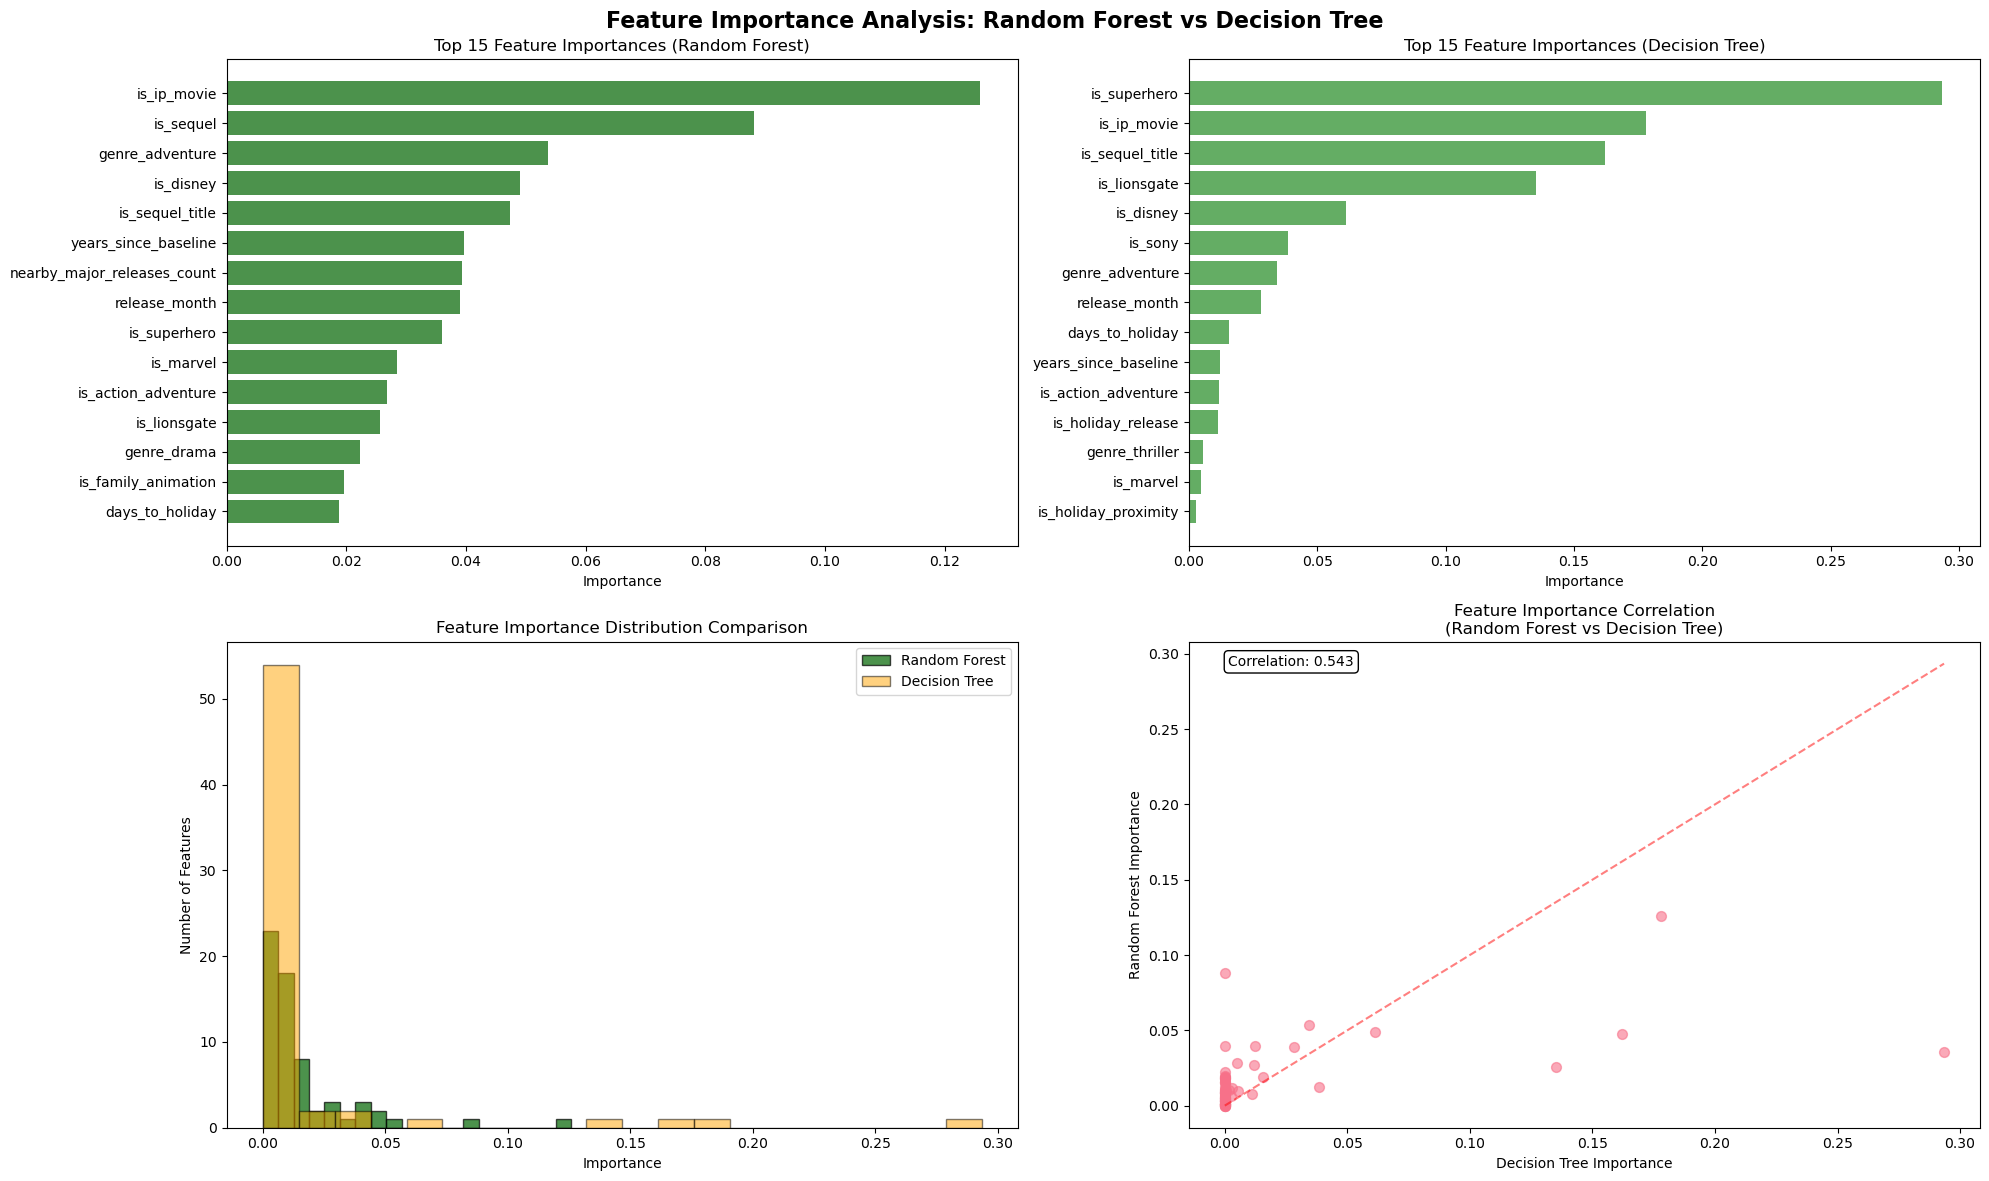


📈 Random Forest Feature Analysis Summary:
   Total features: 63
   Features with importance > 0.01: 29
   Top 5 features account for: 36.4% of total importance
   RF vs DT feature importance correlation: 0.543

🔄 Feature Ranking Differences (RF vs DT):
Top 10 features with largest ranking differences:
                    feature  rf_rank  dt_rank  rank_diff
                  is_sequel        1       57         56
       is_remake_adaptation       16       60         44
nearby_major_releases_count        6       49         43
       is_pre_streaming_era       25       61         36
                     is_mgm       54       25         29
              genre_history       48       20         28
              genre_mystery       46       19         27
         is_holiday_release       36       11         25
       is_post_pandemic_era       39       15         24
              genre_western       59       36         23


In [16]:
# Random Forest Feature Importance Analysis
print("\n🔍 Random Forest Feature Importance Analysis")
print("=" * 60)

# Get feature importances from best Random Forest model
rf_model = best_rf_model.named_steps['rf']
rf_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 most important features
rf_top_features = rf_feature_importance.head(15)
print("Top 15 Most Important Features (Random Forest):")
print(rf_top_features.to_string(index=False))

# Compare with Decision Tree feature importance
dt_model = best_dt_model.named_steps['dt']
dt_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Feature Importance Analysis: Random Forest vs Decision Tree', fontsize=16, fontweight='bold')

# Top 15 Random Forest features
axes[0,0].barh(rf_top_features['feature'][::-1], rf_top_features['importance'][::-1], 
               color='darkgreen', alpha=0.7)
axes[0,0].set_title('Top 15 Feature Importances (Random Forest)')
axes[0,0].set_xlabel('Importance')

# Top 15 Decision Tree features (for comparison)
dt_top_features = dt_feature_importance.head(15)
axes[0,1].barh(dt_top_features['feature'][::-1], dt_top_features['importance'][::-1], 
               color='forestgreen', alpha=0.7)
axes[0,1].set_title('Top 15 Feature Importances (Decision Tree)')
axes[0,1].set_xlabel('Importance')

# Feature importance distribution comparison
axes[1,0].hist(rf_feature_importance['importance'], bins=20, alpha=0.7, 
               color='darkgreen', label='Random Forest', edgecolor='black')
axes[1,0].hist(dt_feature_importance['importance'], bins=20, alpha=0.5, 
               color='orange', label='Decision Tree', edgecolor='black')
axes[1,0].set_title('Feature Importance Distribution Comparison')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Number of Features')
axes[1,0].legend()

# Feature importance correlation between models
# Create merged dataframe for comparison
importance_comparison = pd.merge(
    rf_feature_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    dt_feature_importance[['feature', 'importance']].rename(columns={'importance': 'dt_importance'}),
    on='feature'
)

axes[1,1].scatter(importance_comparison['dt_importance'], importance_comparison['rf_importance'], 
                 alpha=0.6, s=50)
axes[1,1].set_xlabel('Decision Tree Importance')
axes[1,1].set_ylabel('Random Forest Importance')
axes[1,1].set_title('Feature Importance Correlation\n(Random Forest vs Decision Tree)')

# Add diagonal line
max_importance = max(importance_comparison['dt_importance'].max(), 
                    importance_comparison['rf_importance'].max())
axes[1,1].plot([0, max_importance], [0, max_importance], 'r--', alpha=0.5)

# Calculate correlation
correlation = importance_comparison['dt_importance'].corr(importance_comparison['rf_importance'])
axes[1,1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
               transform=axes[1,1].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

plt.tight_layout()
plt.show()

print(f"\n📈 Random Forest Feature Analysis Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Features with importance > 0.01: {(rf_feature_importance['importance'] > 0.01).sum()}")
print(f"   Top 5 features account for: {rf_top_features['importance'].head(5).sum():.1%} of total importance")
print(f"   RF vs DT feature importance correlation: {correlation:.3f}")

# Show top features that differ between models
print(f"\n🔄 Feature Ranking Differences (RF vs DT):")
rf_ranks = {feat: i for i, feat in enumerate(rf_feature_importance['feature'])}
dt_ranks = {feat: i for i, feat in enumerate(dt_feature_importance['feature'])}

rank_differences = []
for feat in feature_cols:
    rf_rank = rf_ranks[feat]
    dt_rank = dt_ranks[feat]
    rank_diff = abs(rf_rank - dt_rank)
    rank_differences.append({'feature': feat, 'rf_rank': rf_rank, 'dt_rank': dt_rank, 'rank_diff': rank_diff})

rank_differences = pd.DataFrame(rank_differences).sort_values('rank_diff', ascending=False)
print("Top 10 features with largest ranking differences:")
print(rank_differences.head(10)[['feature', 'rf_rank', 'dt_rank', 'rank_diff']].to_string(index=False))

## 🚀 Approach 4: XGBoost (Gradient Boosting)

**Why XGBoost?**
- State-of-the-art gradient boosting framework
- Excellent performance on structured/tabular data
- Built-in regularization and feature importance
- Handles missing values automatically
- Often wins machine learning competitions

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Extensive hyperparameter tuning: n_estimators, max_depth, learning_rate, subsample, colsample_bytree
- Feature importance analysis and comparison with tree-based models
- Built-in cross-validation for early stopping

**Expected Outcome**: Test whether gradient boosting provides superior performance for box office prediction.

In [17]:
if XGBOOST_AVAILABLE:
    print("🚀 Setting up XGBoost Regression Models")

    def train_xgboost_strategies(train_data, strategy_name, sample_weights=None):
        """Train XGBoost models with a specific strategy"""
        print(f"\n🚀 Training XGBoost - {strategy_name}")
        
        X_train_strat = train_data[feature_cols]
        y_train_strat = train_data[target]
        y_train_strat_log = np.log1p(y_train_strat)
        
        X_val = val_data[feature_cols]
        y_val = val_data[target]
        y_val_log = np.log1p(y_val)
        
        # XGBoost pipeline (handles missing values automatically)
        xgb_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # Still include for consistency
            ('xgb', xgb.XGBRegressor(random_state=42, verbosity=0))
        ])
        
        # Hyperparameter grid for XGBoost
        xgb_params = {
            'xgb__n_estimators': [100, 200, 300],
            'xgb__max_depth': [3, 4, 5, 6],
            'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'xgb__subsample': [0.8, 0.9, 1.0],
            'xgb__colsample_bytree': [0.8, 0.9, 1.0]
        }
        
        xgb_grid = GridSearchCV(
            xgb_pipeline, xgb_params, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
        )
        
        # Fit with sample weights if provided
        if sample_weights is not None:
            # XGBoost supports sample weights directly
            print("  Running hyperparameter search...")
            xgb_grid.fit(X_train_strat, y_train_strat_log)
            best_params = xgb_grid.best_params_
            
            # Refit with weights
            print("  Refitting with sample weights...")
            xgb_weighted = Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('xgb', xgb.XGBRegressor(
                    n_estimators=best_params['xgb__n_estimators'],
                    max_depth=best_params['xgb__max_depth'],
                    learning_rate=best_params['xgb__learning_rate'],
                    subsample=best_params['xgb__subsample'],
                    colsample_bytree=best_params['xgb__colsample_bytree'],
                    random_state=42,
                    verbosity=0
                ))
            ])
            xgb_weighted.fit(X_train_strat, y_train_strat_log, xgb__sample_weight=sample_weights)
            xgb_best = xgb_weighted
            print(f"  Best params: {best_params}")
        else:
            print("  Running hyperparameter search...")
            xgb_grid.fit(X_train_strat, y_train_strat_log)
            xgb_best = xgb_grid.best_estimator_
            print(f"  Best params: {xgb_grid.best_params_}")
        
        # Evaluate
        results = evaluate_model(xgb_best, X_val, y_val_log, y_val, f"XGBoost - {strategy_name}")
        results['strategy'] = strategy_name
        results['model_object'] = xgb_best
        results['model_type'] = 'XGBoost'
        
        return results

    print("✅ XGBoost framework ready")
else:
    print("❌ XGBoost not available - skipping XGBoost experiments")
    print("   Install with: pip install xgboost")

🚀 Setting up XGBoost Regression Models
✅ XGBoost framework ready


In [18]:
if XGBOOST_AVAILABLE:
    # Train XGBoost models with all three strategies 
    print("🎯 Training XGBoost Models")

    xgb_strategy_results = []

    # Strategy 1: All eras including pandemic
    xgb_results_all = train_xgboost_strategies(train_data_all, "All Eras (2015-2023)")
    xgb_strategy_results.append(xgb_results_all)

    # Strategy 2: Exclude pandemic era
    xgb_results_no_pandemic = train_xgboost_strategies(train_data_no_pandemic, "No Pandemic Era")
    xgb_strategy_results.append(xgb_results_no_pandemic)

    # Strategy 3: Weighted approach (reduced pandemic influence)
    xgb_results_weighted = train_xgboost_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
    xgb_strategy_results.append(xgb_results_weighted)
    
    # Compare XGBoost strategies
    print("\n📊 XGBoost Strategy Comparison")
    print("=" * 70)

    xgb_strategy_comparison = pd.DataFrame([
        {
            'Strategy': r['strategy'],
            'RMSE': f"${r['rmse']:,.0f}",
            'MAE': f"${r['mae']:,.0f}",
            'MAPE': f"{r['mape']:.1f}%",
            'R²': f"{r['r2']:.3f}"
        }
        for r in xgb_strategy_results
    ])

    print(xgb_strategy_comparison.to_string(index=False))

    # Find best XGBoost strategy
    best_xgb_strategy_idx = min(range(len(xgb_strategy_results)), key=lambda i: xgb_strategy_results[i]['rmse'])
    best_xgb_strategy = xgb_strategy_results[best_xgb_strategy_idx]

    print(f"\n🏆 Best XGBoost Strategy: {best_xgb_strategy['strategy']}")
    print(f"   Validation RMSE: ${best_xgb_strategy['rmse']:,.0f}")

    # Store best XGBoost model
    best_xgb_model = best_xgb_strategy['model_object']
else:
    print("❌ XGBoost not available - creating empty results")
    xgb_strategy_results = []

🎯 Training XGBoost Models

🚀 Training XGBoost - All Eras (2015-2023)
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__subsample': 0.9}

XGBoost - All Eras (2015-2023) Performance:
  RMSE: $122,926,508
  MAE:  $67,775,348
  MAPE: 135.2%
  R²:   0.216

🚀 Training XGBoost - No Pandemic Era
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__subsample': 0.9}

XGBoost - No Pandemic Era Performance:
  RMSE: $123,004,165
  MAE:  $67,448,718
  MAPE: 134.1%
  R²:   0.215

🚀 Training XGBoost - Weighted (30% pandemic era)
  Running hyperparameter search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
  Refitting with sample weights..

## 💡 Approach 5: LightGBM (Fast Gradient Boosting)

**Why LightGBM?**
- Microsoft's high-performance gradient boosting framework
- Faster training than XGBoost with similar accuracy
- Built-in categorical feature handling
- Memory efficient and scalable
- Often comparable or superior to XGBoost

**Experimental Design:**
- Same 3 pandemic strategies as previous approaches
- Hyperparameter tuning: n_estimators, max_depth, learning_rate, num_leaves, feature_fraction
- Feature importance analysis and comparison with other tree-based models
- Early stopping to prevent overfitting

**Expected Outcome**: Compare LightGBM performance against XGBoost and other models.

In [19]:
if LIGHTGBM_AVAILABLE:
    print("💡 Setting up LightGBM Regression Models")

    def train_lightgbm_strategies(train_data, strategy_name, sample_weights=None):
        """Train LightGBM models with a specific strategy"""
        print(f"\n💡 Training LightGBM - {strategy_name}")
        
        X_train_strat = train_data[feature_cols]
        y_train_strat = train_data[target]
        y_train_strat_log = np.log1p(y_train_strat)
        
        X_val = val_data[feature_cols]
        y_val = val_data[target]
        y_val_log = np.log1p(y_val)
        
        # LightGBM pipeline
        lgb_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('lgb', lgb.LGBMRegressor(random_state=42, verbosity=-1))
        ])
        
        # Hyperparameter grid for LightGBM
        lgb_params = {
            'lgb__n_estimators': [100, 200, 300],
            'lgb__max_depth': [3, 4, 5, 6, -1],  # -1 means no limit
            'lgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'lgb__num_leaves': [31, 50, 100],
            'lgb__feature_fraction': [0.8, 0.9, 1.0],
            'lgb__bagging_fraction': [0.8, 0.9, 1.0]
        }
        
        lgb_grid = GridSearchCV(
            lgb_pipeline, lgb_params, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
        )
        
        # Fit with sample weights if provided
        if sample_weights is not None:
            # LightGBM supports sample weights directly
            print("  Running hyperparameter search...")
            lgb_grid.fit(X_train_strat, y_train_strat_log)
            best_params = lgb_grid.best_params_
            
            # Refit with weights
            print("  Refitting with sample weights...")
            lgb_weighted = Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('lgb', lgb.LGBMRegressor(
                    n_estimators=best_params['lgb__n_estimators'],
                    max_depth=best_params['lgb__max_depth'],
                    learning_rate=best_params['lgb__learning_rate'],
                    num_leaves=best_params['lgb__num_leaves'],
                    feature_fraction=best_params['lgb__feature_fraction'],
                    bagging_fraction=best_params['lgb__bagging_fraction'],
                    random_state=42,
                    verbosity=-1
                ))
            ])
            lgb_weighted.fit(X_train_strat, y_train_strat_log, lgb__sample_weight=sample_weights)
            lgb_best = lgb_weighted
            print(f"  Best params: {best_params}")
        else:
            print("  Running hyperparameter search...")
            lgb_grid.fit(X_train_strat, y_train_strat_log)
            lgb_best = lgb_grid.best_estimator_
            print(f"  Best params: {lgb_grid.best_params_}")
        
        # Evaluate
        results = evaluate_model(lgb_best, X_val, y_val_log, y_val, f"LightGBM - {strategy_name}")
        results['strategy'] = strategy_name
        results['model_object'] = lgb_best
        results['model_type'] = 'LightGBM'
        
        return results

    print("✅ LightGBM framework ready")
else:
    print("❌ LightGBM not available - skipping LightGBM experiments")
    print("   Install with: pip install lightgbm")

💡 Setting up LightGBM Regression Models
✅ LightGBM framework ready


In [20]:
if LIGHTGBM_AVAILABLE:
    # Train LightGBM models with all three strategies 
    print("🎯 Training LightGBM Models")

    lgb_strategy_results = []

    # Strategy 1: All eras including pandemic
    lgb_results_all = train_lightgbm_strategies(train_data_all, "All Eras (2015-2023)")
    lgb_strategy_results.append(lgb_results_all)

    # Strategy 2: Exclude pandemic era
    lgb_results_no_pandemic = train_lightgbm_strategies(train_data_no_pandemic, "No Pandemic Era")
    lgb_strategy_results.append(lgb_results_no_pandemic)

    # Strategy 3: Weighted approach (reduced pandemic influence)
    lgb_results_weighted = train_lightgbm_strategies(train_data_weighted, "Weighted (30% pandemic era)", sample_weights)
    lgb_strategy_results.append(lgb_results_weighted)
    
    # Compare LightGBM strategies
    print("\n📊 LightGBM Strategy Comparison")
    print("=" * 70)

    lgb_strategy_comparison = pd.DataFrame([
        {
            'Strategy': r['strategy'],
            'RMSE': f"${r['rmse']:,.0f}",
            'MAE': f"${r['mae']:,.0f}",
            'MAPE': f"{r['mape']:.1f}%",
            'R²': f"{r['r2']:.3f}"
        }
        for r in lgb_strategy_results
    ])

    print(lgb_strategy_comparison.to_string(index=False))

    # Find best LightGBM strategy
    best_lgb_strategy_idx = min(range(len(lgb_strategy_results)), key=lambda i: lgb_strategy_results[i]['rmse'])
    best_lgb_strategy = lgb_strategy_results[best_lgb_strategy_idx]

    print(f"\n🏆 Best LightGBM Strategy: {best_lgb_strategy['strategy']}")
    print(f"   Validation RMSE: ${best_lgb_strategy['rmse']:,.0f}")

    # Store best LightGBM model
    best_lgb_model = best_lgb_strategy['model_object']
else:
    print("❌ LightGBM not available - creating empty results")
    lgb_strategy_results = []

🎯 Training LightGBM Models

💡 Training LightGBM - All Eras (2015-2023)
  Running hyperparameter search...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
  Best params: {'lgb__bagging_fraction': 0.8, 'lgb__feature_fraction': 0.8, 'lgb__learning_rate': 0.05, 'lgb__max_depth': 3, 'lgb__n_estimators': 100, 'lgb__num_leaves': 31}

LightGBM - All Eras (2015-2023) Performance:
  RMSE: $118,272,092
  MAE:  $65,487,307
  MAPE: 126.7%
  R²:   0.274

💡 Training LightGBM - No Pandemic Era
  Running hyperparameter search...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
  Best params: {'lgb__bagging_fraction': 0.8, 'lgb__feature_fraction': 1.0, 'lgb__learning_rate': 0.01, 'lgb__max_depth': 3, 'lgb__n_estimators': 300, 'lgb__num_leaves': 31}

LightGBM - No Pandemic Era Performance:
  RMSE: $120,786,396
  MAE:  $65,991,540
  MAPE: 133.3%
  R²:   0.243

💡 Training LightGBM - Weighted (30% pandemic era)
  Running hyperparameter search...
Fitting 5 folds for each of 1

In [21]:
# Save best models from each approach for comparison in notebook 5
import pickle
import os

print("💾 Saving Best Models for Final Comparison")
print("=" * 60)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Collect all available results
all_available_results = []

# Find best Ridge model
best_ridge_idx = min(range(len(strategy_results)), key=lambda i: strategy_results[i]['rmse'])
best_ridge = strategy_results[best_ridge_idx]
all_available_results.append(('ridge', best_ridge))

# Find best Decision Tree model  
best_dt_idx = min(range(len(dt_strategy_results)), key=lambda i: dt_strategy_results[i]['rmse'])
best_dt = dt_strategy_results[best_dt_idx]
all_available_results.append(('decision_tree', best_dt))

# Find best Random Forest model
best_rf_idx = min(range(len(rf_strategy_results)), key=lambda i: rf_strategy_results[i]['rmse'])
best_rf = rf_strategy_results[best_rf_idx]
all_available_results.append(('random_forest', best_rf))

# Find best XGBoost model (if available)
if XGBOOST_AVAILABLE and len(xgb_strategy_results) > 0:
    best_xgb_idx = min(range(len(xgb_strategy_results)), key=lambda i: xgb_strategy_results[i]['rmse'])
    best_xgb = xgb_strategy_results[best_xgb_idx]
    all_available_results.append(('xgboost', best_xgb))

# Find best LightGBM model (if available)
if LIGHTGBM_AVAILABLE and len(lgb_strategy_results) > 0:
    best_lgb_idx = min(range(len(lgb_strategy_results)), key=lambda i: lgb_strategy_results[i]['rmse'])
    best_lgb = lgb_strategy_results[best_lgb_idx]
    all_available_results.append(('lightgbm', best_lgb))

# Save best models and their metadata
models_to_save = {}
for model_name, best_result in all_available_results:
    models_to_save[model_name] = {
        'model': best_result['model_object'],
        'strategy': best_result['strategy'],
        'rmse': best_result['rmse'],
        'mae': best_result['mae'],
        'mape': best_result['mape'],
        'r2': best_result['r2'],
        'type': best_result.get('model_type', model_name.replace('_', ' ').title())
    }

# Save each model
for model_name, model_data in models_to_save.items():
    with open(f'../models/best_{model_name}_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"✅ Saved {model_data['type']} ({model_data['strategy']})")
    print(f"   RMSE: ${model_data['rmse']:,.0f}, R²: {model_data['r2']:.3f}")

# Save feature columns for consistency
with open('../models/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print(f"\n📁 Models saved to ../models/ directory")
saved_models = [f"best_{name}_model.pkl" for name in models_to_save.keys()]
for model_file in saved_models:
    print(f"   • {model_file}")
print(f"   • feature_columns.pkl")

print(f"\n🔄 Use these models in notebook 5 for final comparison")
print(f"📊 Total models available: {len(models_to_save)}")

# Show quick comparison of all models
if len(models_to_save) > 1:
    print(f"\n🏆 Quick Model Comparison (Best RMSE):")
    comparison_list = [(name, data['rmse'], data['r2']) for name, data in models_to_save.items()]
    comparison_list.sort(key=lambda x: x[1])  # Sort by RMSE
    
    for i, (name, rmse, r2) in enumerate(comparison_list, 1):
        print(f"   {i}. {name.replace('_', ' ').title()}: RMSE ${rmse:,.0f}, R² {r2:.3f}")
    
    best_overall = comparison_list[0]
    print(f"\n🥇 Overall Best: {best_overall[0].replace('_', ' ').title()}")
    print(f"   RMSE: ${best_overall[1]:,.0f}")
    print(f"   R²: {best_overall[2]:.3f}")

💾 Saving Best Models for Final Comparison
✅ Saved Ridge (No Pandemic Era)
   RMSE: $126,935,522, R²: 0.164
✅ Saved Decision Tree (Weighted (30% pandemic era))
   RMSE: $119,866,144, R²: 0.255
✅ Saved Random Forest (No Pandemic Era)
   RMSE: $127,603,100, R²: 0.155
✅ Saved XGBoost (Weighted (30% pandemic era))
   RMSE: $122,743,335, R²: 0.218
✅ Saved LightGBM (All Eras (2015-2023))
   RMSE: $118,272,092, R²: 0.274

📁 Models saved to ../models/ directory
   • best_ridge_model.pkl
   • best_decision_tree_model.pkl
   • best_random_forest_model.pkl
   • best_xgboost_model.pkl
   • best_lightgbm_model.pkl
   • feature_columns.pkl

🔄 Use these models in notebook 5 for final comparison
📊 Total models available: 5

🏆 Quick Model Comparison (Best RMSE):
   1. Lightgbm: RMSE $118,272,092, R² 0.274
   2. Decision Tree: RMSE $119,866,144, R² 0.255
   3. Xgboost: RMSE $122,743,335, R² 0.218
   4. Ridge: RMSE $126,935,522, R² 0.164
   5. Random Forest: RMSE $127,603,100, R² 0.155

🥇 Overall Best: Li